In [2]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import matplotlib.pyplot as plt
import mapclassify
from shapely.ops import nearest_points
from shapely.geometry import LineString

#pd.options.display.max_colwidth= 200
#pd.set_option('display.max_rows', 20)

# Preparing Data

## Agencies Data

In [45]:
sp_shp = gpd.read_file('C:/Users/Ricardo/Documents/R-Projetos/Exploratory-Data-Analysis-Bancarization/data/raw/municipio_sp.shp')

In [46]:
gdf_agencias_sp = pd.read_csv('C:/Users/Ricardo/Documents/R-Projetos/Exploratory-Data-Analysis-Bancarization/data/processed/agencias_latlong.csv', sep=';')

In [47]:
# Set crs to use degrees in the first moment
# https://gis.stackexchange.com/questions/345071/matching-x-and-y-axis-coordinates-of-two-geopandas-geometries-to-overlay-them
gdf_agencias_sp_points = gpd.GeoDataFrame(gdf_agencias_sp, geometry=gpd.points_from_xy(gdf_agencias_sp['lon'], gdf_agencias_sp['lat']), crs=4326)

In [48]:
# Then, set the crs of points to the crs of shapefile map which is in meters
gdf_agencias_sp_points = gdf_agencias_sp_points.to_crs(sp_shp.crs)

In [49]:
# Spatial join to get only the points inside polygon
gdf_agencias_sp_points_join = gpd.sjoin(gdf_agencias_sp_points, sp_shp, predicate='within')

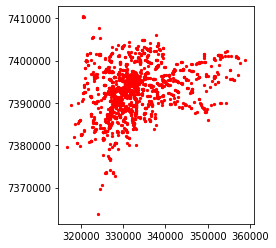

In [50]:
gdf_agencias_sp_points_join.plot(marker='o', color='red', markersize=5);

# Calculating New Features

## Centroid

In [51]:
sp_shp["centroid"] = sp_shp.centroid

In [16]:
#sp_shp['menor_distancia'] = sp_shp.centroid.distance(gdf_agencias_sp_points_join)

C:\Users\Ricardo\Anaconda3\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [52]:
sp_shp.centroid

0     POINT (353834.211 7392983.063)
1     POINT (322676.391 7380084.928)
2     POINT (348377.652 7395944.389)
3     POINT (321658.159 7398867.737)
4     POINT (339562.029 7390046.264)
                   ...              
91    POINT (338955.010 7398846.264)
92    POINT (333123.055 7390644.123)
93    POINT (345103.311 7395997.013)
94    POINT (331310.534 7396682.496)
95    POINT (332534.414 7395260.261)
Length: 96, dtype: geometry

## Nearest Agency

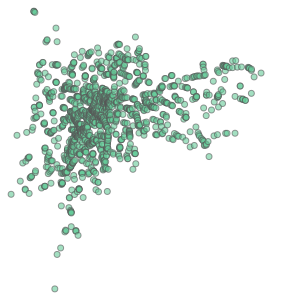

In [53]:
# Unary_union is used to create a multipoint structure
# https://autogis-site.readthedocs.io/en/latest/notebooks/L3/04_nearest-neighbour.html
gdf_agencias_sp_points_join.unary_union

In [54]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [55]:
sp_shp["agencia_mais_proxima"] = sp_shp.apply(get_nearest_values, other_gdf=gdf_agencias_sp_points_join, point_column="centroid", axis=1)

In [56]:
sp_shp["agencia_mais_proxima"]

0     POINT (352302.4364832666 7394955.645497645)
1     POINT (322363.2000065215 7381017.757298688)
2     POINT (347951.8908333202 7396067.959863355)
3     POINT (321810.2118726268 7398886.744106924)
4     POINT (339147.9798142896 7390336.702797015)
                         ...                     
91    POINT (338331.0322886222 7398781.362539189)
92    POINT (333144.3713397966 7390496.377464311)
93    POINT (344819.8109995762 7395537.840644479)
94    POINT (331295.8973385801 7396524.690199891)
95     POINT (332583.5356943328 7395260.09730478)
Name: agencia_mais_proxima, Length: 96, dtype: object

## Creating a GeoDataFrame of the Lines Between Centroid and Nearest Agency

In [57]:
sp_shp['link'] = sp_shp.apply(lambda row: LineString([row['centroid'], row['agencia_mais_proxima']]), axis=1)

In [58]:
link = gpd.GeoDataFrame(sp_shp["link"], geometry=sp_shp["link"], crs=sp_shp.crs)

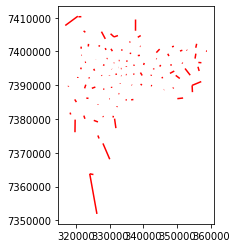

In [59]:
link.plot(marker='o', color='red', markersize=5);

## Plot

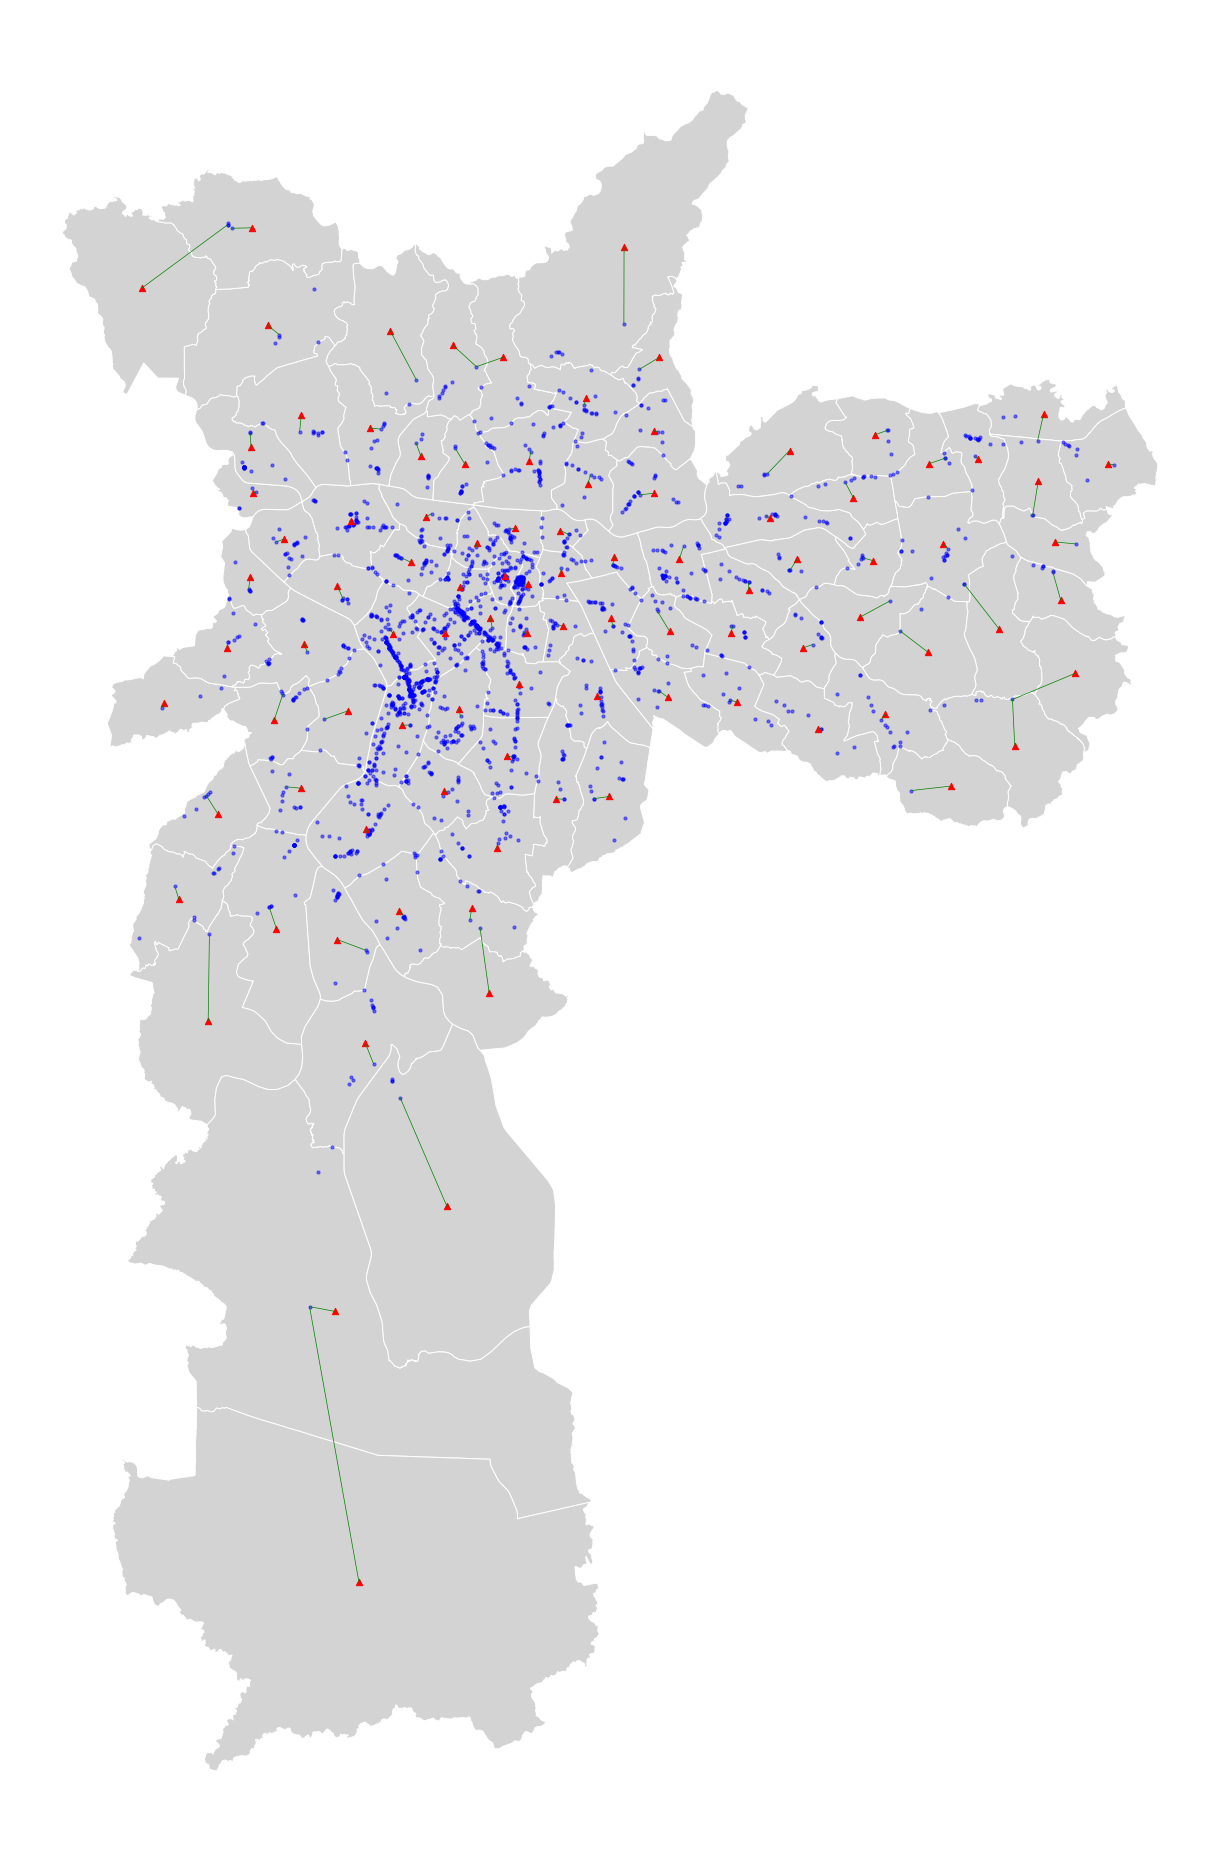

In [66]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot polygons
sp_shp.plot(ax=ax, facecolor='lightgrey', edgecolor="white")

# Plot points
gdf_agencias_sp_points_join.plot(ax=ax, color='blue', markersize=10, alpha=0.5)
sp_shp.centroid.plot(ax=ax, color='red', markersize=40, marker="^")

# Plot lines
link.plot(ax=ax, color='green', lw=0.7)

ax.axis("off")
plt.show()

## Calculating Min, Max, Mean and Std Metrics

In [67]:
sp_shp['menor_distancia'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).min())
sp_shp['maior_distancia'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).max())
sp_shp['distancia_media'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).mean())
sp_shp['distancia_desvio_padrao'] = sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).std())

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


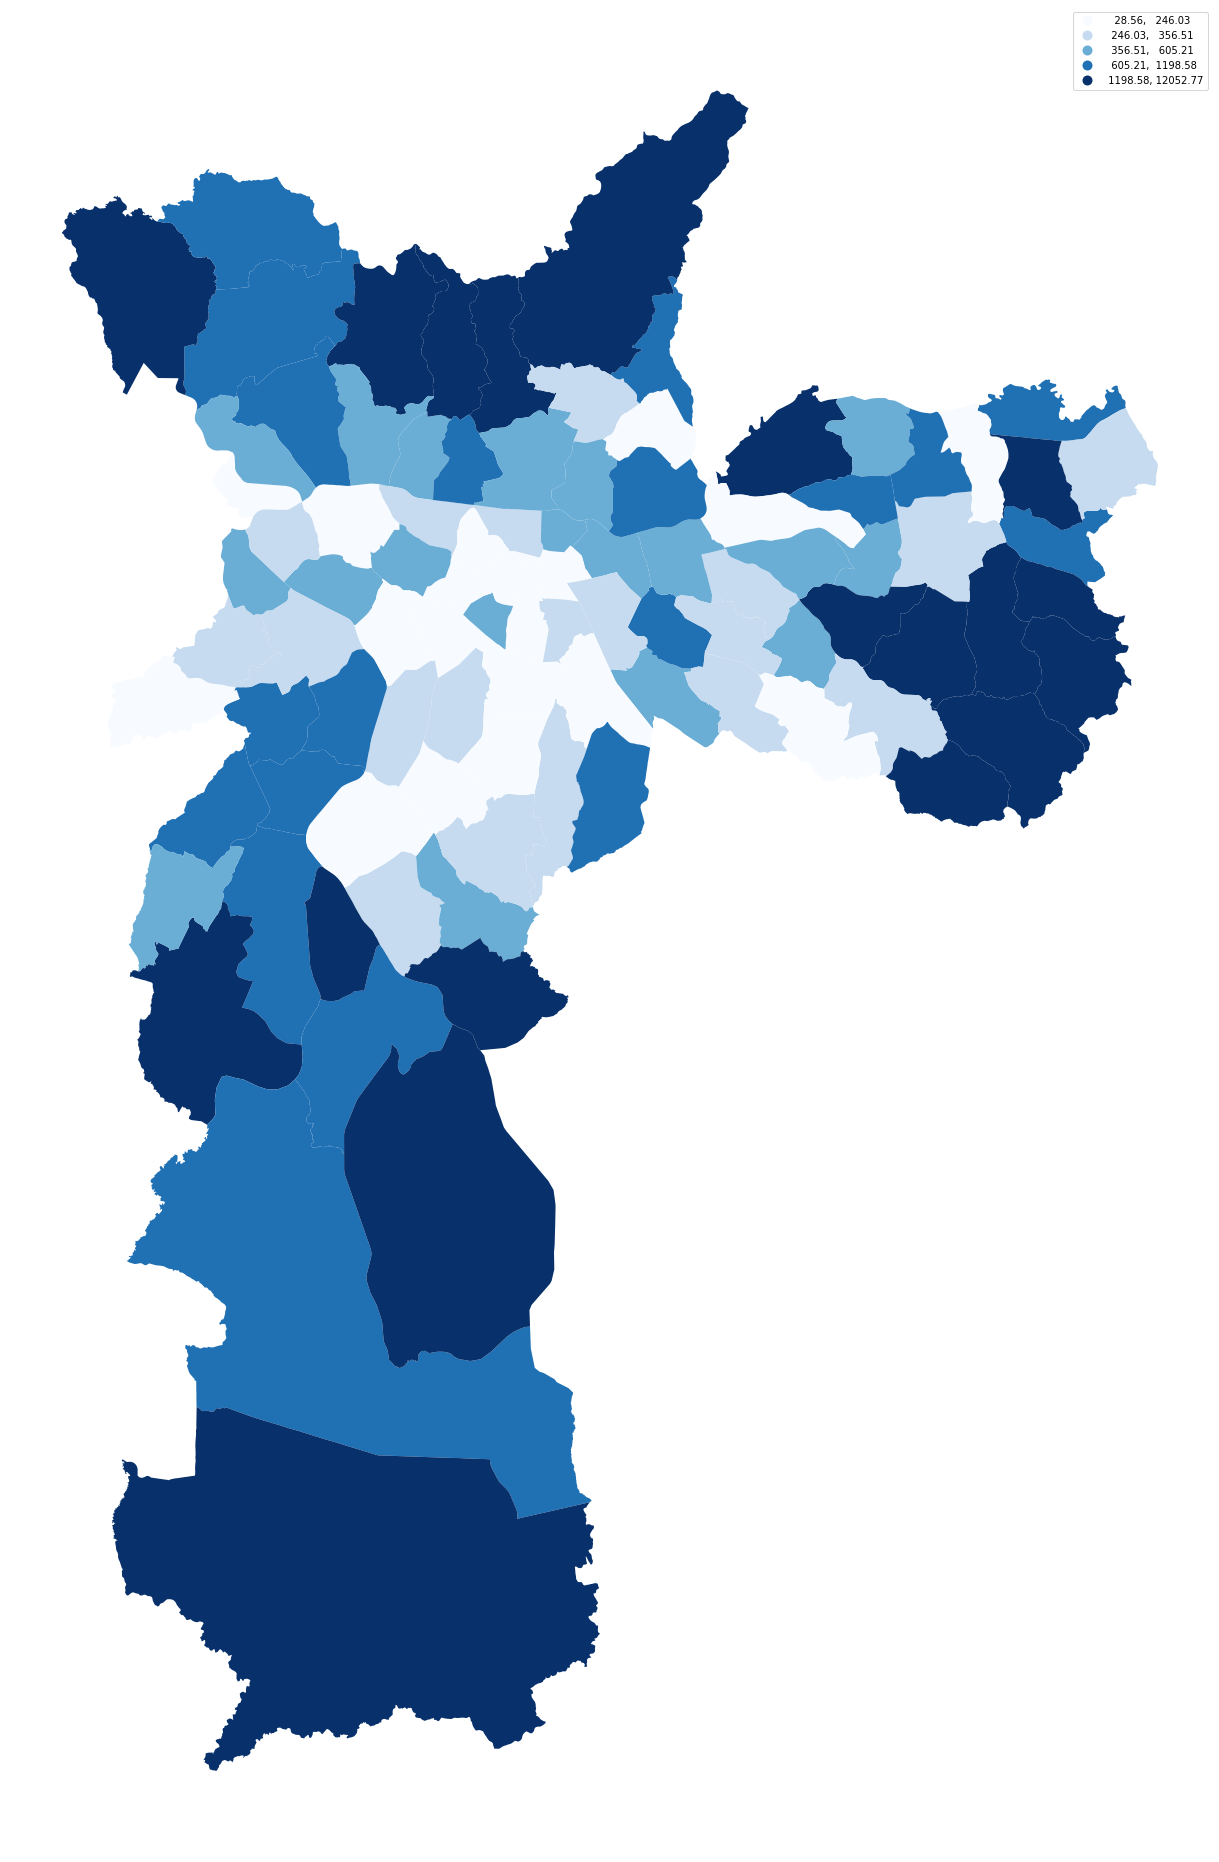

In [68]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='menor_distancia', scheme="Quantiles", k= 5, cmap="Blues", legend=True, ax=ax)

ax.axis("off")
plt.show()

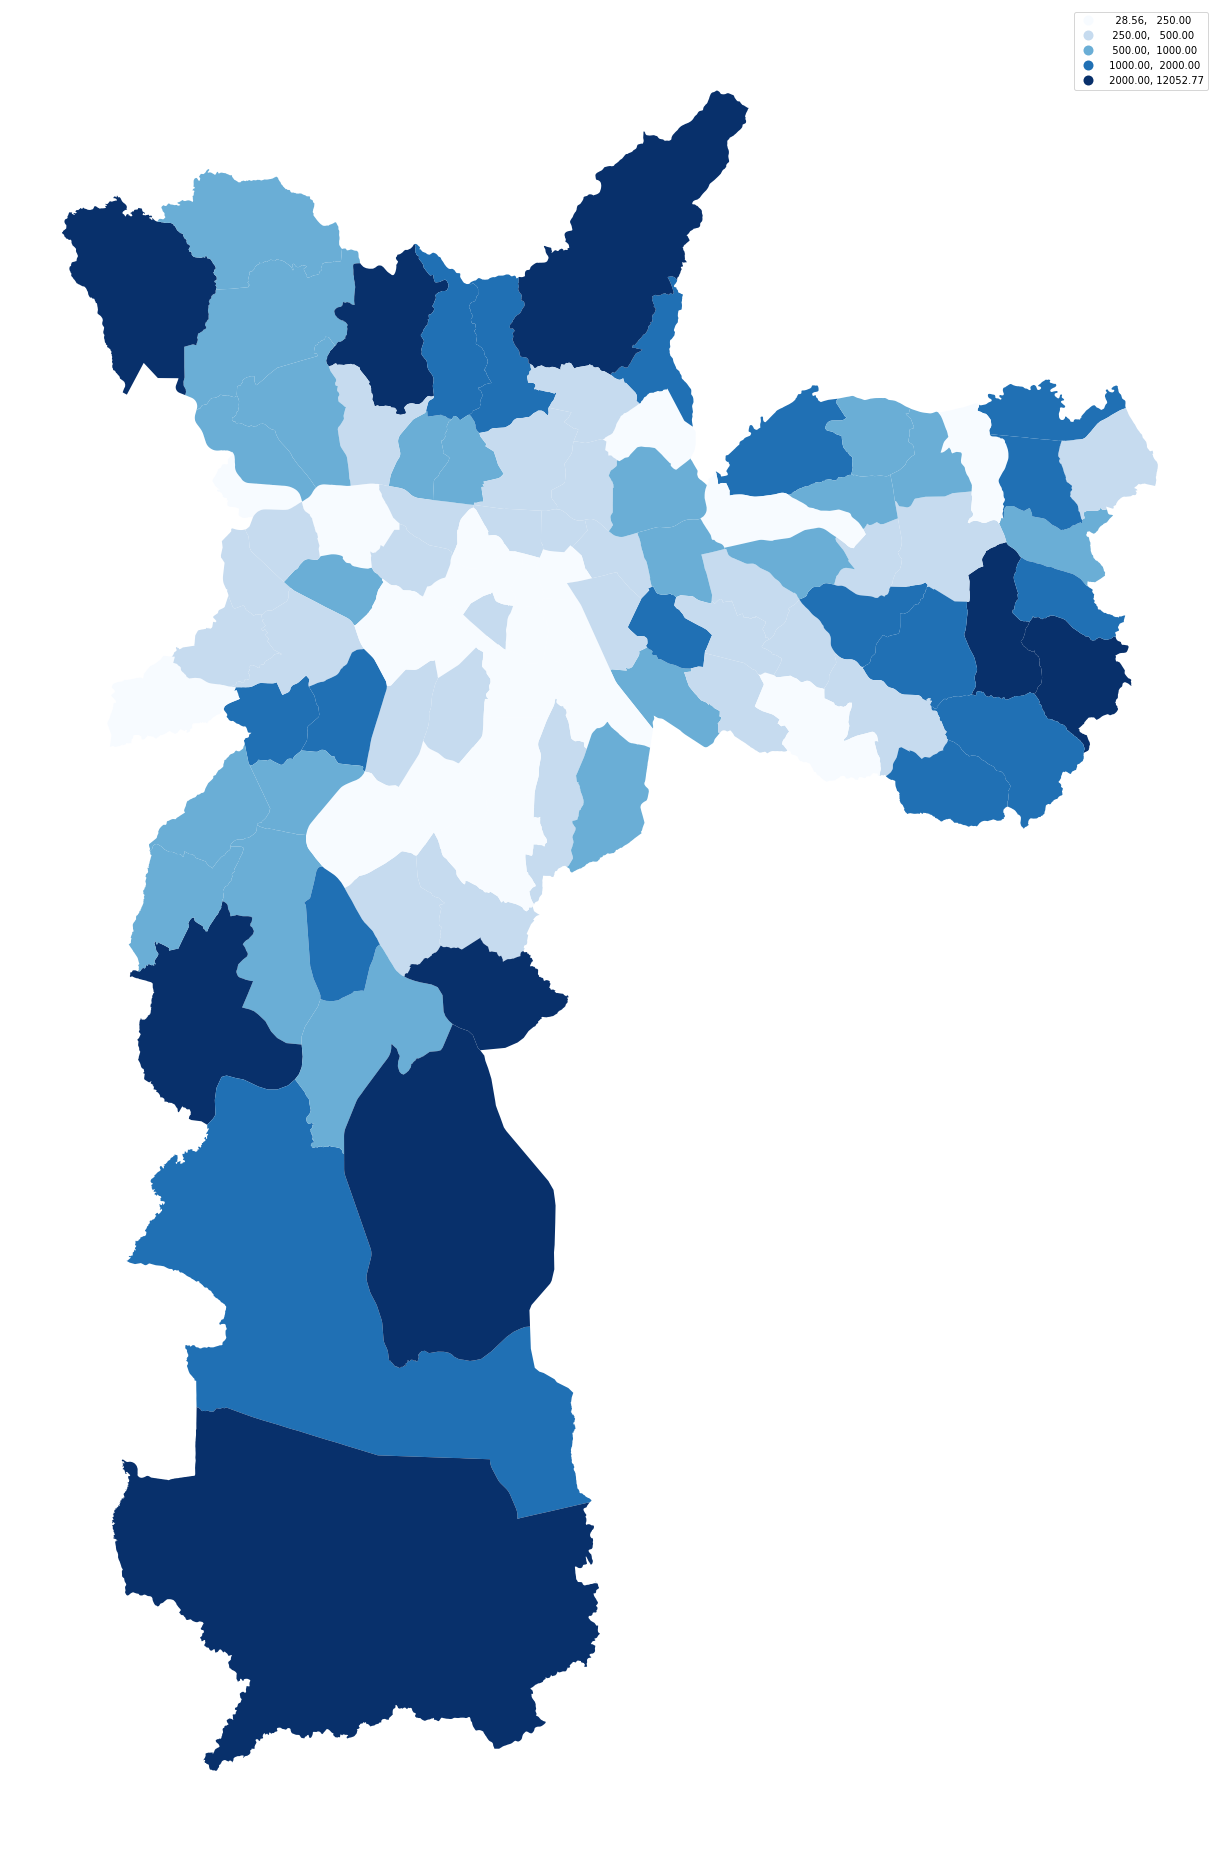

In [69]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='menor_distancia', scheme="User_Defined", classification_kwds=dict(bins=[250,500,1000,2000]), cmap="Blues", legend=True, ax=ax)

ax.axis("off")
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


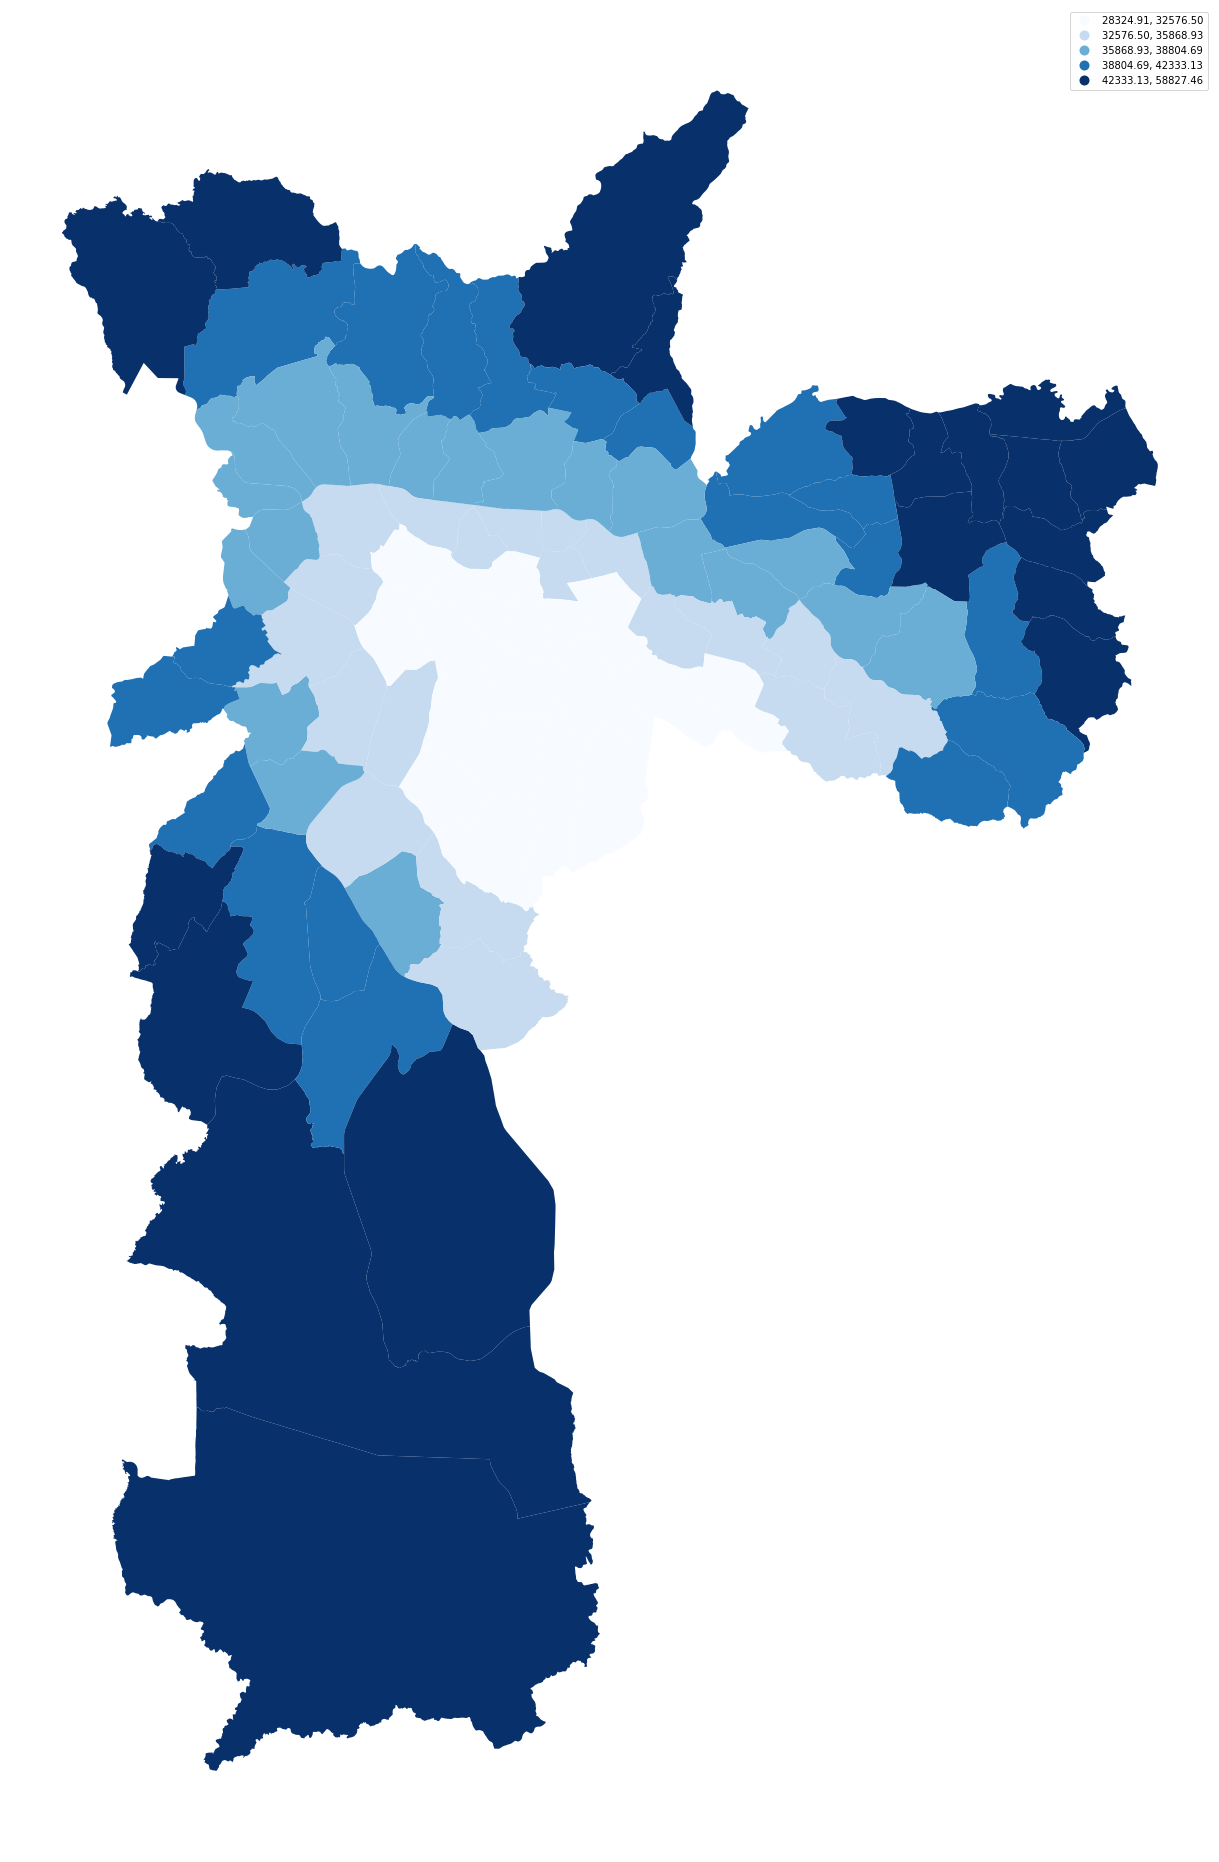

In [70]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='maior_distancia', scheme="Quantiles", k= 5, cmap="Blues", legend=True, ax=ax)

ax.axis("off")
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


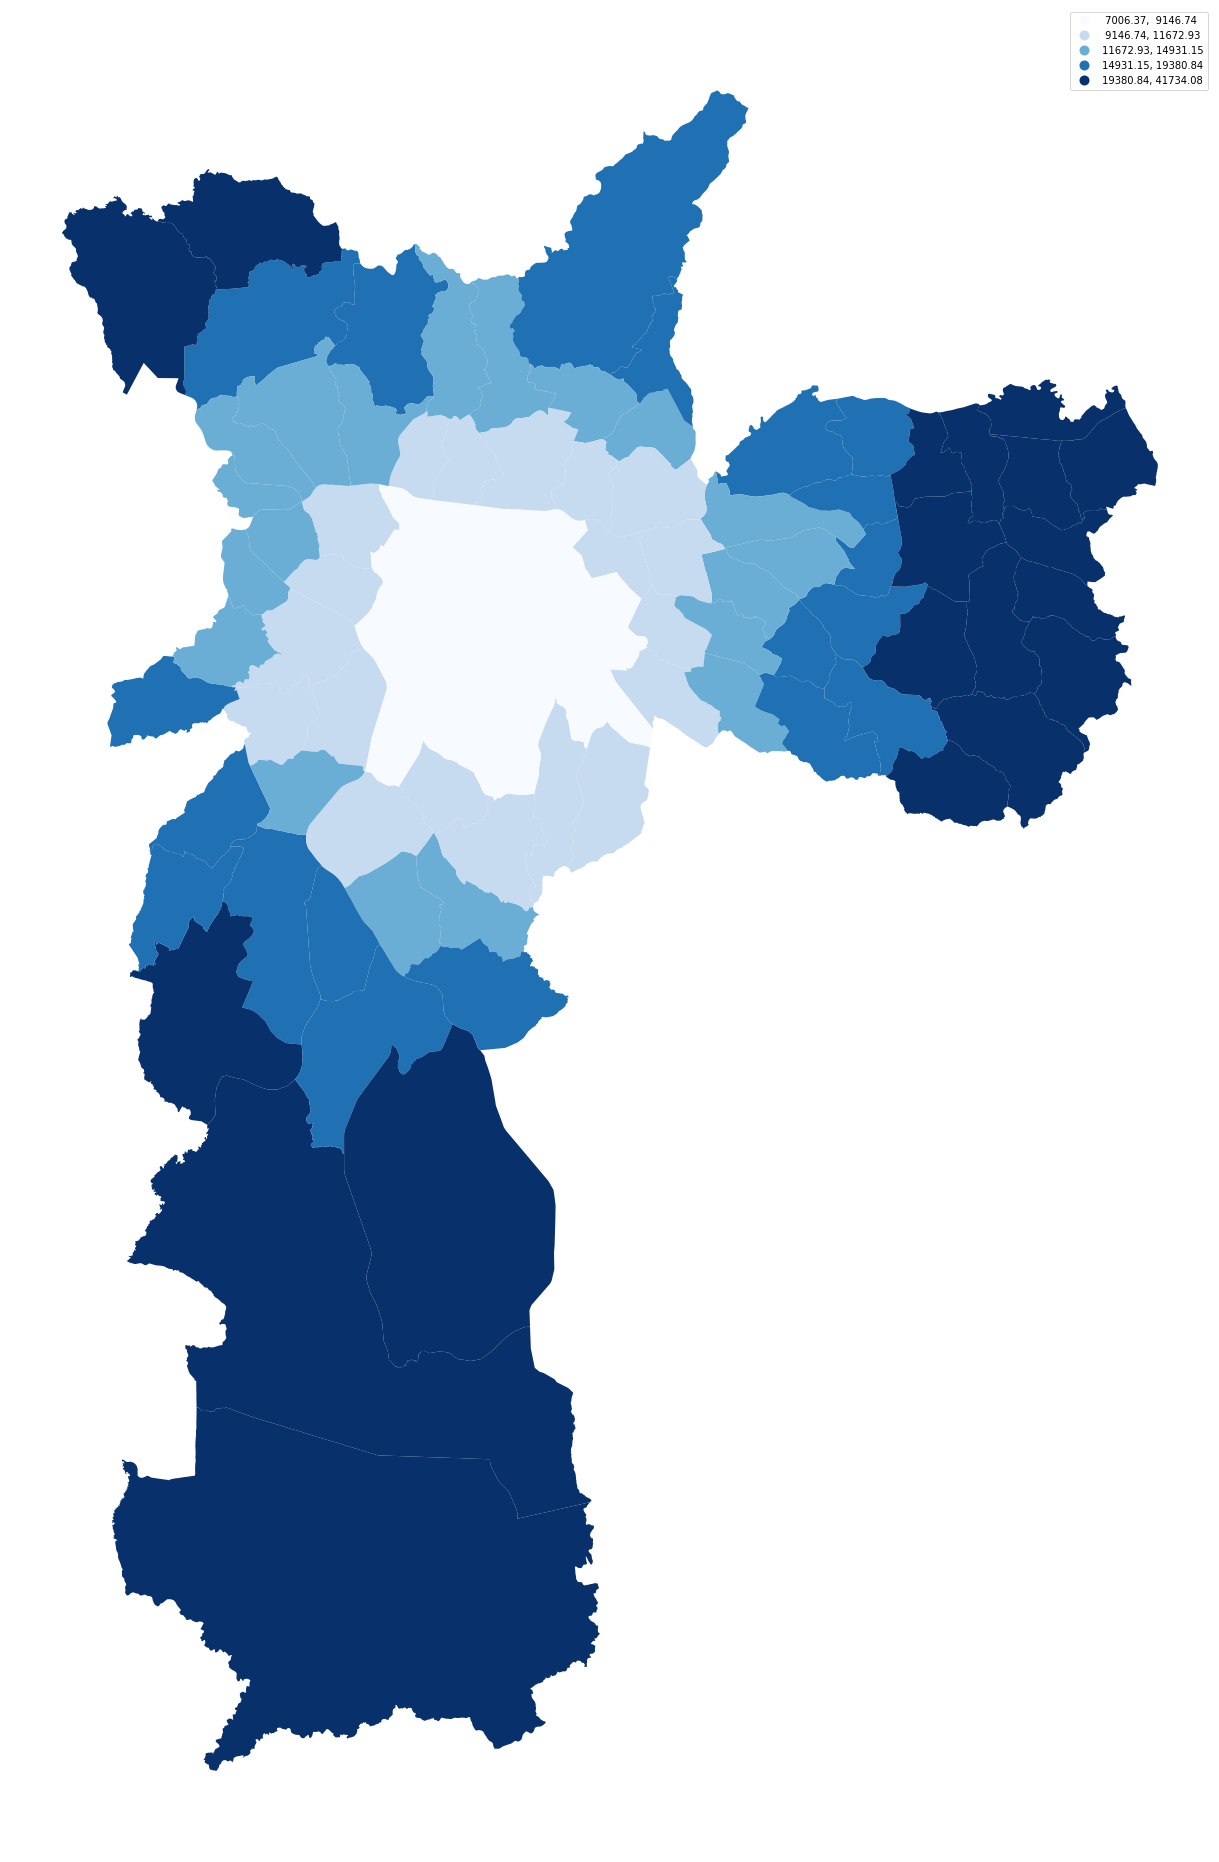

In [71]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='distancia_media', scheme="Quantiles", k= 5, cmap="Blues", legend=True, ax=ax)

ax.axis("off")
plt.show()

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


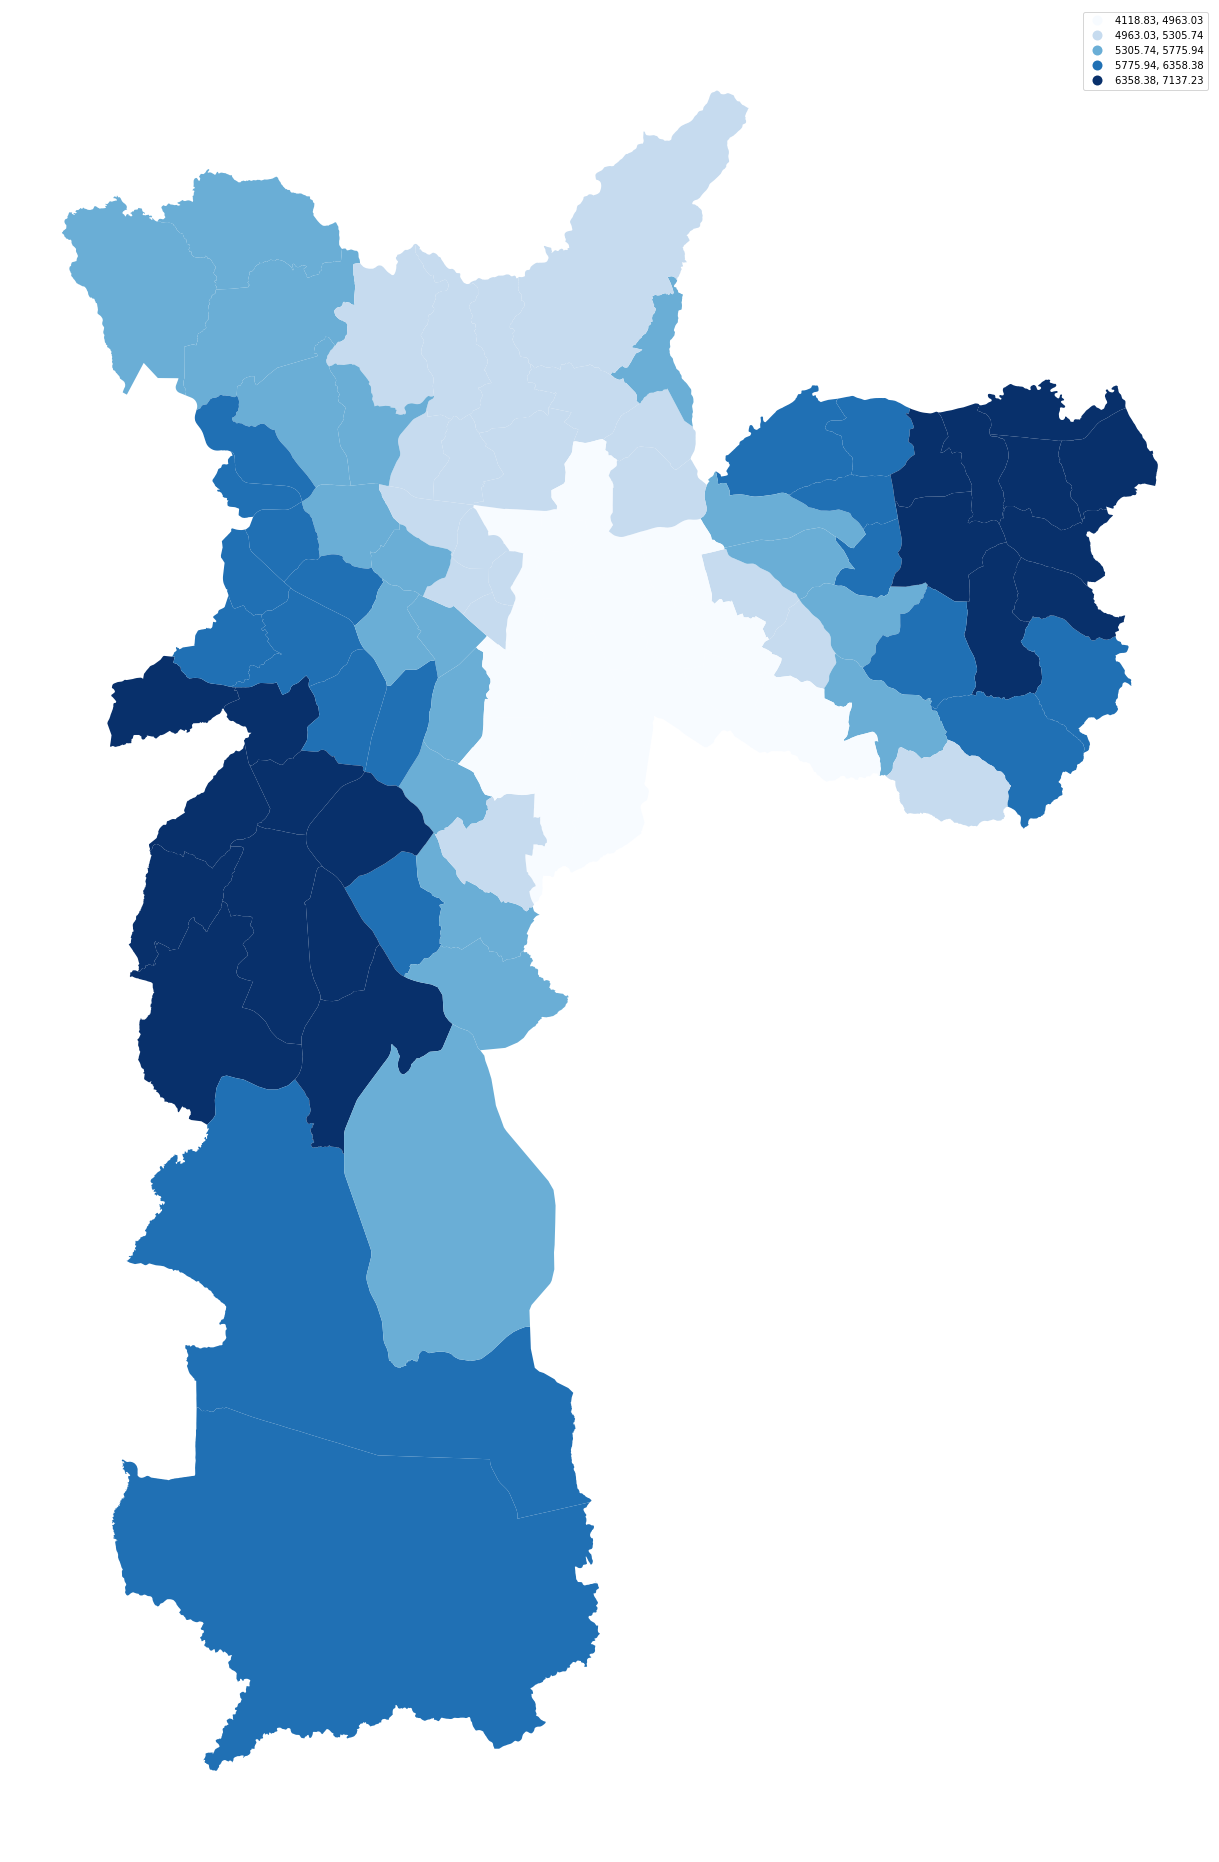

In [72]:
fig, ax = plt.subplots(figsize=(40,34))

# Set bg colors
ax.set(facecolor = "white")
fig.patch.set_facecolor('white')

# Plot
sp_shp.plot(column='distancia_desvio_padrao', scheme="Quantiles", k= 5, cmap="Blues", legend=True, ax=ax)

ax.axis("off")
plt.show()

In [21]:
sp_shp.centroid.apply(lambda x: gdf_agencias_sp_points_join.distance(x).min())

0     2497.481121
1      984.001823
2      443.331322
3      153.236753
4      505.758166
         ...     
91     627.344200
92     149.275299
93     539.640498
94     158.482741
95      49.121678
Length: 96, dtype: float64

In [73]:
 mapclassify.Quantiles(sp_shp['menor_distancia'], k=5)

C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Quantiles                   

      Interval         Count
----------------------------
[   28.56,   246.03] |    20
(  246.03,   356.51] |    19
(  356.51,   605.21] |    19
(  605.21,  1198.58] |    19
( 1198.58, 12052.77] |    19

In [74]:
 mapclassify.NaturalBreaks(sp_shp['menor_distancia'], k=5)

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\metrics

NaturalBreaks               

      Interval         Count
----------------------------
[   28.56,   731.72] |    63
(  731.72,  1712.74] |    23
( 1712.74,  3318.88] |     6
( 3318.88,  5099.06] |     3
( 5099.06, 12052.77] |     1